In [2]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [34]:
# load SnP500 data
df_spy = pd.read_parquet("../data/prices_sp500.parquet")

In [ ]:
# load DRL portfolio
model_dir = "../models/20250603_011024/"

# get csv files in dir
# fname contains portfolio
csv_files = sorted(
    [f for f in os.listdir(model_dir) if f.endswith(".csv") and "portfolio" in f]
)
print(csv_files)

# load csv files
dfs = []
for file in csv_files:
    idx = file.split("_")[0]
    year = 2011 + int(idx)
    df = pd.read_csv(os.path.join(model_dir, file))
    df["year"] = year
    df.reset_index(inplace=True)
    df.rename(columns={"index": "trading_day"}, inplace=True)
    # reorder columns such that year, trading_day are first then the rest
    df = df[
        ["year", "trading_day"]
        + [col for col in df.columns if col not in ["year", "trading_day"]]
    ]
    dfs.append(df)

df_drl_port = pd.concat(dfs, ignore_index=True)
df_drl_port

['0_portfolio.csv', '1_portfolio.csv', '2_portfolio.csv', '3_portfolio.csv', '4_portfolio.csv']


,year,trading_day,portfolio_value,cash,w_c,w_XLF,w_XLK,w_XLV,w_XLY,w_XLP,...,s_XLK,s_XLV,s_XLY,s_XLP,s_XLE,s_XLI,s_XLU,s_XLB,s_XLRE,s_XLC
0,2011,0,100000.000000,12468.041468,0.124680,0.1682,0.0618,0.0618,0.0617,0.0618,...,287,219,184,271,378,230,274,641,0,0
1,2011,1,100142.491684,11175.679071,0.111598,0.0552,0.1502,0.0881,0.0550,0.0553,...,696,314,163,243,290,557,670,209,0,0
2,2011,2,100319.975781,20535.559946,0.204701,0.0583,0.1082,0.1583,0.0799,0.0581,...,501,564,235,256,131,216,259,599,0,0
3,2011,3,100190.421704,14441.609502,0.144142,0.0717,0.0716,0.0715,0.0716,0.1947,...,331,254,210,863,357,277,320,271,0,0
4,2011,4,100405.479789,11631.665339,0.115847,0.1559,0.0574,0.0571,0.0570,0.0573,...,266,203,168,254,353,335,523,516,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,2015,246,120184.944242,12599.018045,0.104830,0.1405,0.1403,0.0515,0.1163,0.0624,...,377,103,184,180,116,310,166,397,0,0
1249,2015,247,120304.366314,23790.379059,0.197752,0.1035,0.0532,0.0529,0.1442,0.1447,...,143,105,229,417,119,117,466,150,0,0
1250,2015,248,120499.167572,24106.913589,0.200059,0.0536,0.1112,0.1309,0.1452,0.1455,...,298,260,230,420,120,118,172,150,0,0
1251,2015,249,119702.448372,12883.655128,0.107631,0.1438,0.1437,0.0528,0.1067,0.0527,...,386,105,169,152,119,318,171,405,0,0


In [52]:
df_drl_port_res = df_drl_port.groupby("year", as_index=False)["portfolio_value"].last()

years = df["year"].unique()
start_dates = pd.to_datetime([f"{yr}-01-01" for yr in years])
end_dates = pd.to_datetime([f"{yr}-12-31" for yr in years])

spy_start_prices = [
    df_spy.loc[df_spy.index > start, "^GSPC"].iloc[0] for start in start_dates
]
spy_end_prices = [df_spy.loc[df_spy.index < end, "^GSPC"].iloc[-1] for end in end_dates]

shares_start = 100_000 / pd.Series(spy_start_prices)
snp_values = shares_start * pd.Series(spy_end_prices)
df_drl_port_res["snp_value"] = snp_values.values

df_drl_port_res

# TODO : add MVO portfolio values in other cols
# then identify best and worst performing model / agent

,year,portfolio_value,snp_value
0,2011,107490.116512,98878.028447
1,2012,121539.105981,109817.079023
2,2013,111090.877983,125892.007150
3,2014,99301.254156,113557.468959
4,2015,119671.245071,100250.712097


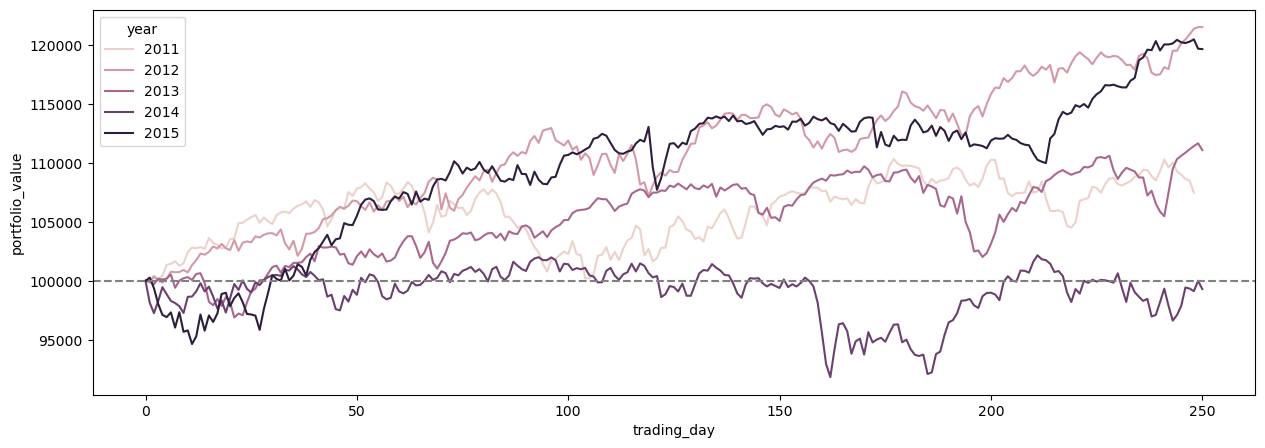

In [29]:
# plot portfolio value development
# with hue = year
plt.figure(figsize=(15, 5))
sns.lineplot(x="trading_day", y="portfolio_value", hue="year", data=df_drl_port)
plt.axhline(y=100_000, color="grey", linestyle="--")
plt.show()

In [67]:
# load MVO portfolio

folders = [
    "20250606_0140_mvo_backtest_[2011-01-01,2011-12-31]",
    "20250606_0144_mvo_backtest_[2012-01-01,2012-12-31]",
    "20250606_0146_mvo_backtest_[2013-01-01,2013-12-31]",
    "20250606_0148_mvo_backtest_[2014-01-01,2014-12-31]",
    "20250606_0149_mvo_backtest_[2015-01-01,2015-12-31]",
]

dfs = []
for idx, folder in enumerate(folders):
    year = 2011 + idx
    df_mvo = pd.read_parquet(f"../results/{folder}/mvo_history.parquet")
    df_mvo_yr = df_mvo.groupby('lookback')[['portfolio_value']].last().T
    dfs.append(df_mvo_yr)
    

In [72]:
df_mvo_all = pd.concat(dfs, ignore_index=True)
df_final = pd.concat([df_drl_port_res, df_mvo_all], axis=1)
df_final

,year,portfolio_value,snp_value,10,30,60,90,120,150,252,504,756,882
0,2011,107490.116512,98878.028447,105936.757735,101100.370343,110602.272243,114846.969397,118108.519068,114079.926495,100151.068171,110585.983162,106720.422081,114259.798737
1,2012,121539.105981,109817.079023,118363.262842,111410.319828,105673.660206,101251.993391,104650.515273,105243.893355,111470.115002,110366.379911,113310.873274,111485.950926
2,2013,111090.877983,125892.007150,114215.963351,118405.057713,124660.048079,127109.876636,127985.187750,131915.918396,133672.800772,128440.778767,125634.077820,125084.354475
3,2014,99301.254156,113557.468959,112061.080539,107991.713924,114748.928545,106770.522110,104941.185822,108567.048412,116314.421185,118778.904084,120444.892466,118260.323557
4,2015,119671.245071,100250.712097,86740.471479,85414.786723,89636.531189,86343.462217,90272.520371,98284.136989,100039.787344,99573.100718,101762.013597,100627.566742


In [62]:
df_temp = df_drl_port_res.copy()
# add each row of df_mvo_yr as col to df_temp in the correct year






,year,portfolio_value,snp_value
0,2011,107490.116512,98878.028447
1,2012,121539.105981,109817.079023
2,2013,111090.877983,125892.007150
3,2014,99301.254156,113557.468959
4,2015,119671.245071,100250.712097
